<font color=blue><h1>Automatic generation of car insurance contract</h1> </font>

 <font color=red><h1>Libraries</h1> </font>

In [ ]:
pip uninstall opencv-python--user

In [ ]:
pip install opencv-python==4.5.4.60

In [ ]:
pip install pillow

In [1]:
import pytesseract
import keras_ocr
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import imutils
import sys
from imutils.object_detection import non_max_suppression
from collections import namedtuple
from skimage.io import imread, imshow
from imutils.contours import sort_contours
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance, ImageOps
import re

<font color=red><h1>The templates: </h1> </font>

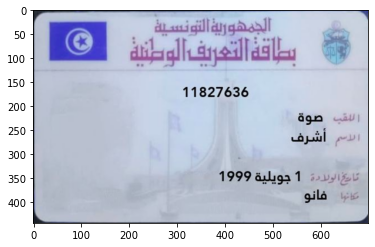

In [2]:
templateIDF = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\templates\a.jpg")
templateIDF = imutils.resize(templateIDF, width=700)
plt.imshow(templateIDF)

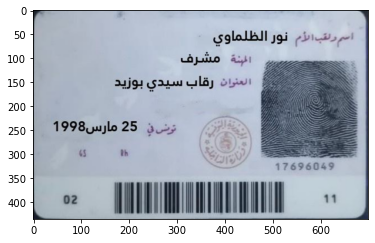

In [3]:
templateIDB = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\templates\b.jpg")
templateIDB = imutils.resize(templateIDB, width=700)
plt.imshow(templateIDB)

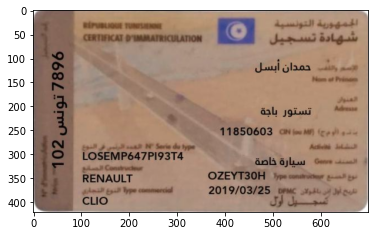

In [4]:
templateCRF = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\templates\c.jpg")
templateCRF = imutils.resize(templateCRF, width=700)
plt.imshow(templateCRF)

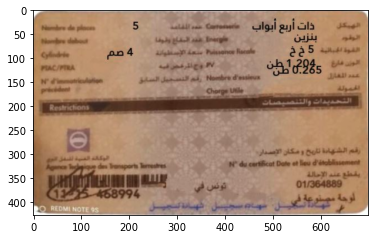

In [5]:
templateCRB = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\templates\d.jpg")
templateCRB = imutils.resize(templateCRB, width=700)
plt.imshow(templateCRB)

<font color=red><h1>I. Input: </h1> </font>

### Insert the front of the ID card

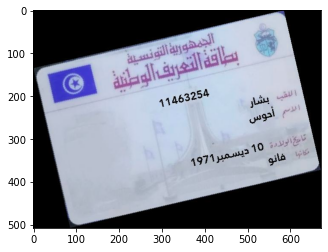

In [31]:
IDfront = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\IDCardFront\front (17).jpg")
plt.imshow(IDfront)

### Insert the back of the ID card

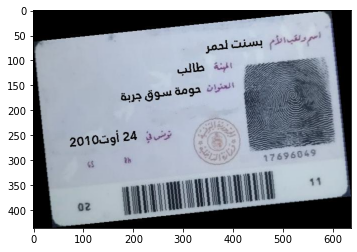

In [32]:
IDback = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\IDCardBack\back (17).jpg")
plt.imshow(IDback)

### Insert the front of the CR card

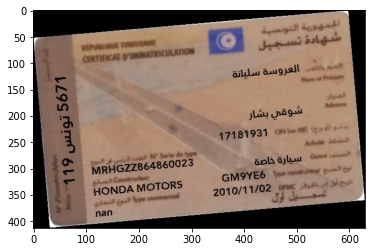

In [33]:
CRfront = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\CrCardFront\cgF20.jpg")
plt.imshow(CRfront)

### Insert the back of the CR card

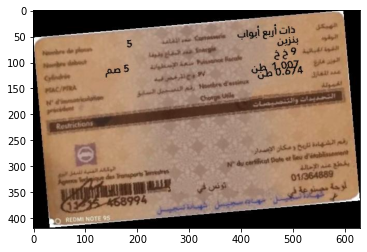

In [34]:
CRback = cv2.imread(r"C:\Users\ASUS\Downloads\dataset\CrCardback\cgB20.jpg")
plt.imshow(CRback)

<font color=red><h1>II. Preprocessing: </h1> </font>

### Thresholding:

In [10]:
def thresholding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # threshold the image using Otsu's thresholding method
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return(thresh)

### Image enhancement:

In [11]:
def enhancing(image):
    enh_sha = ImageEnhance.Sharpness(image)
    sharpness = 3.0
    image_sharped = enh_sha.enhance(sharpness)
    return(image_sharped)

### Skew correction and resizing:

In [35]:
def align_images(image, template, maxFeatures=99999999, keepPercent=0.2,
	debug=False):
	# convert both the input image and template to grayscale
	imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    
	# use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	# match the features
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)
    
    
    # sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
	# check to see if we should visualize the matched keypoints
	if debug:
		matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
#		cv2.imshow("Matched Keypoints", matchedVis)
#		cv2.waitKey(0)
        
        
	# allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	# loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt
        
    # compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))
	# return the aligned image
	return aligned

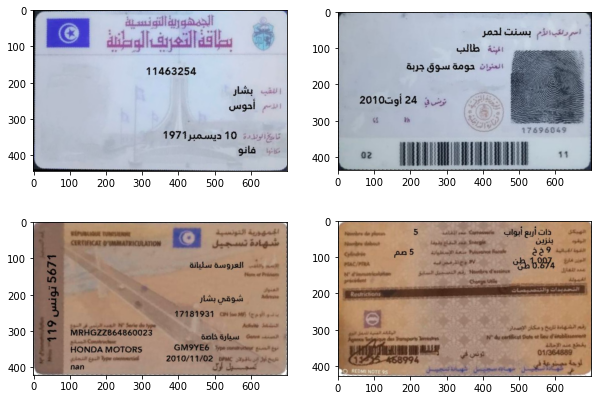

In [36]:
alignedIDF = align_images(IDfront, templateIDF, debug=True)
alignedIDB = align_images(IDback, templateIDB, debug=True)
alignedCRF = align_images(CRfront, templateCRF, debug=True)
alignedCRB = align_images(CRback, templateCRB, debug=True)

# resize both the aligned and template images so we can easily align them with templates
alignedIDF = imutils.resize(alignedIDF, width=700)
alignedIDB = imutils.resize(alignedIDB, width=700)
alignedCRF = imutils.resize(alignedCRF, width=700)
alignedCRB = imutils.resize(alignedCRB, width=700)

#Apply the thresholing on aligned images
threshIDF=thresholding(alignedIDF)
threshIDB=thresholding(alignedIDB)
threshCRF=thresholding(alignedCRF)
threshCRB=thresholding(alignedCRB)

#Apply the enhancement on aligned images
#enhanceIDF=enhancing(alignedIDF)
#enhanceIDB=enhancing(alignedIDB)
#enhanceCRF=enhancing(alignedCRF)
#enhanceCRB=enhancing(alignedCRB)

#Visualize the aligned images
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(alignedIDF)
fig.add_subplot(rows, columns, 2)
plt.imshow(alignedIDB)
fig.add_subplot(rows, columns, 3)
plt.imshow(alignedCRF)
fig.add_subplot(rows, columns, 4)
plt.imshow(alignedCRB)


<font color=red><h1>III. Optical character recognition: </h1> </font>

### initializing the OCR:

In [14]:
text_reader = easyocr.Reader(['ar','en'], gpu = True) #Initialzing the ocr

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


### Bounding box setting, OCR and results saving for each image:

In [37]:
#----------------------------------ID card front----------------------------------------------------------------
idn= text_reader.readtext(alignedIDF[150:200 , 280:480], detail = 0)
last_name = text_reader.readtext(alignedIDF[208:248 , 430:620], detail = 0)
name = text_reader.readtext(alignedIDF[242:320 , 380:625], detail = 0)
dob = text_reader.readtext(alignedIDF[330:373 , 330:575], detail = 0)
pob = text_reader.readtext(alignedIDF[374:430 , 370:630], detail = 0)
print(idn,last_name,name,dob,pob)

['11463254'] ['بشار'] ['أحوس'] ['10 ديسمبر 1971'] ['فانو']


In [38]:
#---------------------------------ID card back-------------------------------------------------------------------
mother_name= text_reader.readtext(alignedIDB[ 39:80, 300:544 ], detail = 0)
job = text_reader.readtext(alignedIDB[ 85:126, 146:402], detail = 0)
adress = text_reader.readtext(alignedIDB[ 125:200,69:390 ], detail = 0)
date = text_reader.readtext(alignedIDB[ 217:280,16:316 ], detail = 0)
print(mother_name,job,adress,date)

['بسنت', 'لحمر'] ['طالب'] ['حومة سوق جربة'] ['24 أوت 0 201', 'نرن ب']


In [39]:
cr_name = text_reader.readtext(alignedCRF[104:168 , 333:584], detail = 0)
cr_address = text_reader.readtext(alignedCRF[165:225 , 350:616], detail = 0)
cr_id = text_reader.readtext(alignedCRF[234:264 , 345:508], detail = 0)
cr_car_type = text_reader.readtext(alignedCRF[302:327 , 391:580], detail = 0)
cr_constructor_type = text_reader.readtext(alignedCRF[327:361 , 348:497], detail = 0)
cr_dpmc = text_reader.readtext(alignedCRF[358:395 , 319:507], detail = 0)
cr_type_serial = text_reader.readtext(alignedCRF[293:321 , 86:346], detail = 0)
cr_constructor = text_reader.readtext(alignedCRF[339:364 , 94:283], detail = 0)
cr_commercial_type = text_reader.readtext(alignedCRF[387:409 , 92:293], detail = 0)
cr_serial = alignedCRF[73:338 , 32:76]
cv2.imwrite("serialNumber.jpg", cr_serial)
tmp = cv2.imread(r"C:\Users\ASUS\Downloads\serialNumber.jpg")
Rotated_image = imutils.rotate_bound(tmp, angle=90)
cv2.imwrite("serialNumber.jpg", Rotated_image);

cr_serial_nbr = text_reader.readtext(Rotated_image, detail = 0)
print(cr_name,cr_address,cr_id,cr_car_type,cr_constructor_type,cr_dpmc,cr_type_serial,cr_constructor,cr_commercial_type,cr_serial_nbr)

['العروسة سليانة'] ['شوقى بشار'] ['17181931'] ['سبارة خاصة'] ['GM9YE6'] ['2010/11/02'] ['MRHG7Z864860023'] ['HONDA MOTOF'] ['٨8/'] ['5671 تونس 119']


In [40]:
#--------------------------------CR card back---------------------------------------------------------------------
cr_carros= text_reader.readtext(alignedCRB[14:49 , 437:626], detail = 0)
cr_energy  = text_reader.readtext(alignedCRB[50:70 , 466:604] , detail = 0)
cr_power = text_reader.readtext(alignedCRB[71:97 , 468:595], detail = 0)
cr_empty_weight = text_reader.readtext(alignedCRB[100:119 , 431:611], detail = 0)
cr_essieurx = text_reader.readtext(alignedCRB[117:153 , 486:612], detail = 0)
cr_chair = text_reader.readtext(alignedCRB[22:50 , 177:255], detail = 0)
cr_cylindre = text_reader.readtext(alignedCRB[75:107 , 133:243], detail = 0)
print(cr_carros,cr_energy,cr_power,cr_empty_weight,cr_essieurx,cr_chair,cr_cylindre)

['ذات أربع', 'أبواب'] ['بئرين'] ['ذ'] [] ['0.674 من'] ['5'] ['5 صم']


<font color=red><h1>IV. The insurance contract generation: </h1> </font>

## Functions we need in orger to generate the contract

### ListToString

In [42]:
def listToString(s): 
    
    str1 = " " 
    
    return (str1.join(s))

### Total weight of car

In [43]:
string1=listToString(cr_empty_weight)
charge1=re.sub('[^.0-9]', "", string1)

string2=listToString(cr_essieurx)
charge2=re.sub('[^.0-9]', "", string2)

charge=float(charge1)+float(charge2)

ValueError: could not convert string to float: ''

### Serial number function

In [46]:
z=listToString(cr_serial_nbr)
a=z[10:13]

In [44]:
def Contrat():
    font = ImageFont.truetype(r"C:\Users\ASUS\Downloads\font\Janna LT Bold\Janna LT Bold.ttf", size=16)
    templateCon = Image.open(r'C:\Users\ASUS\Downloads\dataset\templates\template contrat.png')
    draw = ImageDraw.Draw(templateCon)
    draw.text((690, 689), get_display(arabic_reshaper.reshape(str(listToString(cr_name)))),anchor='rs',font=font, fill='black')
    draw.text((644, 720), get_display(arabic_reshaper.reshape(str(listToString(cr_address)))),anchor='rs', font=font,fill='black')
    draw.text((360, 652), get_display(arabic_reshaper.reshape("شخص طبيعي")),anchor='rs', font=font,fill='black')
    draw.text((611, 743), get_display(arabic_reshaper.reshape(str(listToString(idn)))),anchor='rs', font=font,fill='black')
    draw.text((668, 761), get_display(arabic_reshaper.reshape(str(listToString(job)))),anchor='rs', font=font,fill='black')
    draw.text((474, 822), get_display(arabic_reshaper.reshape(str(listToString(cr_constructor)))),anchor='rs', font=font,fill='black')
    draw.text((477, 839), get_display(arabic_reshaper.reshape(str(listToString(cr_constructor_type)))),anchor='rs', font=font,fill='black')
    draw.text((452, 854),str(a),anchor='rs', font=font,fill='black') 
    draw.text((497, 887), get_display(arabic_reshaper.reshape(str(listToString(cr_serial_nbr)))),anchor='rs', font=font,fill='black') 
    draw.text((517, 905), get_display(arabic_reshaper.reshape(str(listToString(cr_type_serial)))),anchor='rs', font=font,fill='black') 
    draw.text((459, 920), get_display(arabic_reshaper.reshape(str(listToString(cr_energy)))),anchor='rs', font=font,fill='black')
    draw.text((451, 938), get_display(arabic_reshaper.reshape(str(listToString(cr_power)))),anchor='rs', font=font,fill='black')
    draw.text((495, 955), get_display(arabic_reshaper.reshape(str(listToString(cr_carros)))),anchor='rs', font=font,fill='black')
    draw.text((480, 973), get_display(arabic_reshaper.reshape(str(listToString(cr_dpmc)))),anchor='rs', font=font,fill='black')
    draw.text((453, 992), str(charge1),anchor='rs', font=font,fill='black')
    draw.text((472, 1008) ,str(charge),anchor='rs', font=font,fill='black')
    draw.text((470, 1026), str(charge2),anchor='rs', font=font,fill='black')
    draw.text((450, 1059), get_display(arabic_reshaper.reshape(str(listToString(cr_chair)))),anchor='rs', font=font,fill='black')
    return templateCon

## Contract generation

In [45]:
path=f"C:\\Users\\ASUS\\Downloads\\dataset\\contracts\\"
filename="contract_"
x=listToString(idn)
#generate the cards
contr = Contrat()
#output
contr.save(path+filename+x+'.png')
  